In [1]:
"""
Test script for SensingMasks sweep over rho x gamma.

Produces:
  - A large grid figure (6 x 6 cells). Each cell has two small subplots:
      left:  histogram of agent endowments s_i
      right: histogram of pairwise Jaccard overlaps
    Titles include (gamma, rho, mu, fraction_clipped).
  - A second figure: scatter with rho (x) vs gamma (y), color = mean pairwise overlap, size = variance.

Parameters:
  - matrix size: 100 x 50
  - num_agents: 256
  - density: 0.5
  - full-rank: r = 50 (so robust sampling will skip low-rank checks)
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sensing import SensingMasks

In [2]:
def compute_pairwise_overlaps_from_masks(masks: torch.Tensor):
    """
    masks: torch.BoolTensor of shape [num_agents, total_entries]
    returns: numpy array of pairwise Jaccard overlaps (length = nC2)
    """
    masks_np = masks.cpu().numpy().astype(bool)
    A = masks_np.shape[0]
    overlaps = []
    for i in range(A):
        mi = masks_np[i]
        for j in range(i + 1, A):
            mj = masks_np[j]
            inter = np.count_nonzero(mi & mj)
            union = np.count_nonzero(mi | mj)
            overlaps.append((inter / union) if union > 0 else 0.0)
    return np.array(overlaps, dtype=float)

Saved alpha_vs_gamma_mapping.png

Alpha values at selected gamma points:
 gamma_curve  γ=0.00  γ=0.25   γ=0.50   γ=0.75  γ=1.00
         0.3      50 0.18137 0.049485 0.020223    0.01
         0.5      50 0.70711  0.12117 0.031302    0.01
           1      50   5.946  0.70711  0.08409    0.01
           2      50  29.362    5.946  0.41524    0.01
           5      50  49.586   38.316    6.625    0.01


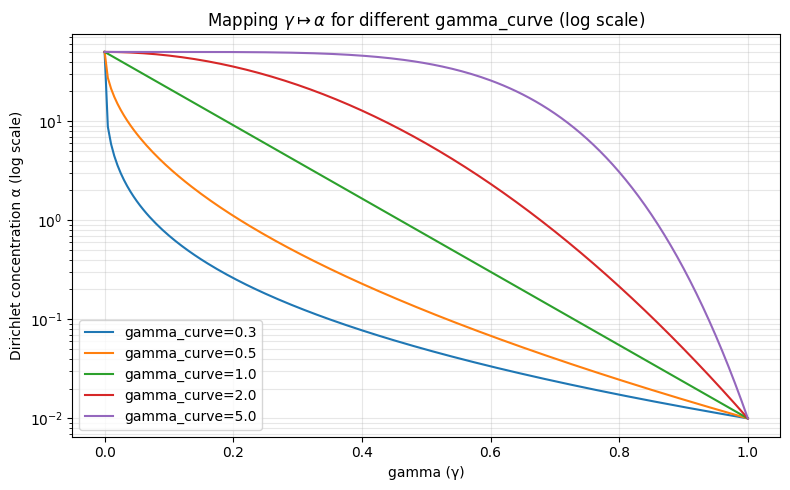

In [22]:
"""
Inspect concentration alpha vs gamma for several gamma_curve values.

Mapping used:
    gamma_adj = gamma ** gamma_curve
    log10_alpha = (1 - gamma_adj) * log10(alpha_max) + gamma_adj * log10(alpha_min)
    alpha = 10 ** log10_alpha

Tune:
    - alpha_max: concentration for γ=0 (near-uniform)
    - alpha_min: concentration for γ=1 (highly-skewed)
    - gamma_curve: exponent on γ controlling where transition happens
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def alpha_from_gamma(gamma, alpha_max=50.0, alpha_min=0.01, gamma_curve=0.5):
    gamma = np.asarray(gamma)
    gamma_adj = np.power(gamma, gamma_curve)  # gamma' = gamma ** gamma_curve
    log10_alpha = (1.0 - gamma_adj) * np.log10(alpha_max) + gamma_adj * np.log10(alpha_min)
    return np.power(10.0, log10_alpha)

# parameters to try
alpha_max = 50.0
alpha_min = 0.01
gamma_curves = [0.3, 0.5, 1.0, 2.0, 5.0]   # try <1 (sensitivity at low γ), =1 (linear in γ), >1 (sensitivity near 1)
gammas = np.linspace(0.0, 1.0, 201)

plt.figure(figsize=(8, 5))
for gc in gamma_curves:
    alphas = alpha_from_gamma(gammas, alpha_max=alpha_max, alpha_min=alpha_min, gamma_curve=gc)
    plt.plot(gammas, alphas, label=f"gamma_curve={gc}")

plt.yscale("log")
plt.xlabel("gamma (γ)")
plt.ylabel("Dirichlet concentration α (log scale)")
plt.title(r"Mapping $\gamma \mapsto \alpha$ for different $\mathrm{gamma\_curve}$ (log scale)")
plt.grid(which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("alpha_vs_gamma_mapping.png", dpi=200)
print("Saved alpha_vs_gamma_mapping.png")

# Also print a small table for select gamma values
sample_gammas = [0.0, 0.25, 0.5, 0.75, 1.0]
rows = []
for gc in gamma_curves:
    vals = alpha_from_gamma(sample_gammas, alpha_max=alpha_max, alpha_min=alpha_min, gamma_curve=gc)
    rows.append([gc] + [float(v) for v in vals])
df = pd.DataFrame(rows, columns=["gamma_curve"] + [f"γ={g:.2f}" for g in sample_gammas])
print("\nAlpha values at selected gamma points:")
print(df.to_string(index=False, float_format=lambda x: f"{x:.5g}"))

In [23]:
# --- grid settings ---
n_rho = 4
n_gamma = 6
rhos = np.linspace(0.0, 1.0, n_rho)      # rho values (x)
gammas = np.linspace(0.0, 1.0, n_gamma)  # gamma values (y)

# problem settings
T = 100
M = 50
rank = 50            # full-rank for your matrices
num_agents = 256
density = 0.5
future_only = False  # keep full global_known set (so G = floor(density * T*M))
seed = 12345        

# set seeds for reproducibility (optional)
if seed is not None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    
# Minimal TemporalData stub used by SensingMasks constructor
class TemporalDataStub:
    def __init__(self, t, m, n_matrices=1):
        self.t = t
        self.m = m
    def __len__(self):
        return 1
TemporalData = TemporalDataStub(T, M)

# Storage for scatter metrics
scatter_rho = []
scatter_gamma = []
scatter_mean_overlap = []
scatter_var_overlap = []
scatter_fraction_clipped = []

Saved figure: sensing_masks_grid_histograms.png

Summary table (rho, gamma, mean_overlap, var_overlap, fraction_clipped):
rho=0.00, gamma=0.00 -> mean=0.0020, var=0.000108, clipped_frac=0.000
rho=0.33, gamma=0.00 -> mean=0.1997, var=0.000791, clipped_frac=0.000
rho=0.67, gamma=0.00 -> mean=0.4982, var=0.005275, clipped_frac=0.000
rho=1.00, gamma=0.00 -> mean=0.8904, var=0.010147, clipped_frac=0.496
rho=0.00, gamma=0.20 -> mean=0.0017, var=0.000094, clipped_frac=0.000
rho=0.33, gamma=0.20 -> mean=0.1835, var=0.006366, clipped_frac=0.004
rho=0.67, gamma=0.20 -> mean=0.4414, var=0.041417, clipped_frac=0.133
rho=1.00, gamma=0.20 -> mean=0.6739, var=0.059653, clipped_frac=0.410
rho=0.00, gamma=0.40 -> mean=0.0013, var=0.000073, clipped_frac=0.000
rho=0.33, gamma=0.40 -> mean=0.1382, var=0.022272, clipped_frac=0.066
rho=0.67, gamma=0.40 -> mean=0.2781, var=0.073568, clipped_frac=0.246
rho=1.00, gamma=0.40 -> mean=0.3660, var=0.114215, clipped_frac=0.352
rho=0.00, gamma=0.60 -> mean=0.0004, v

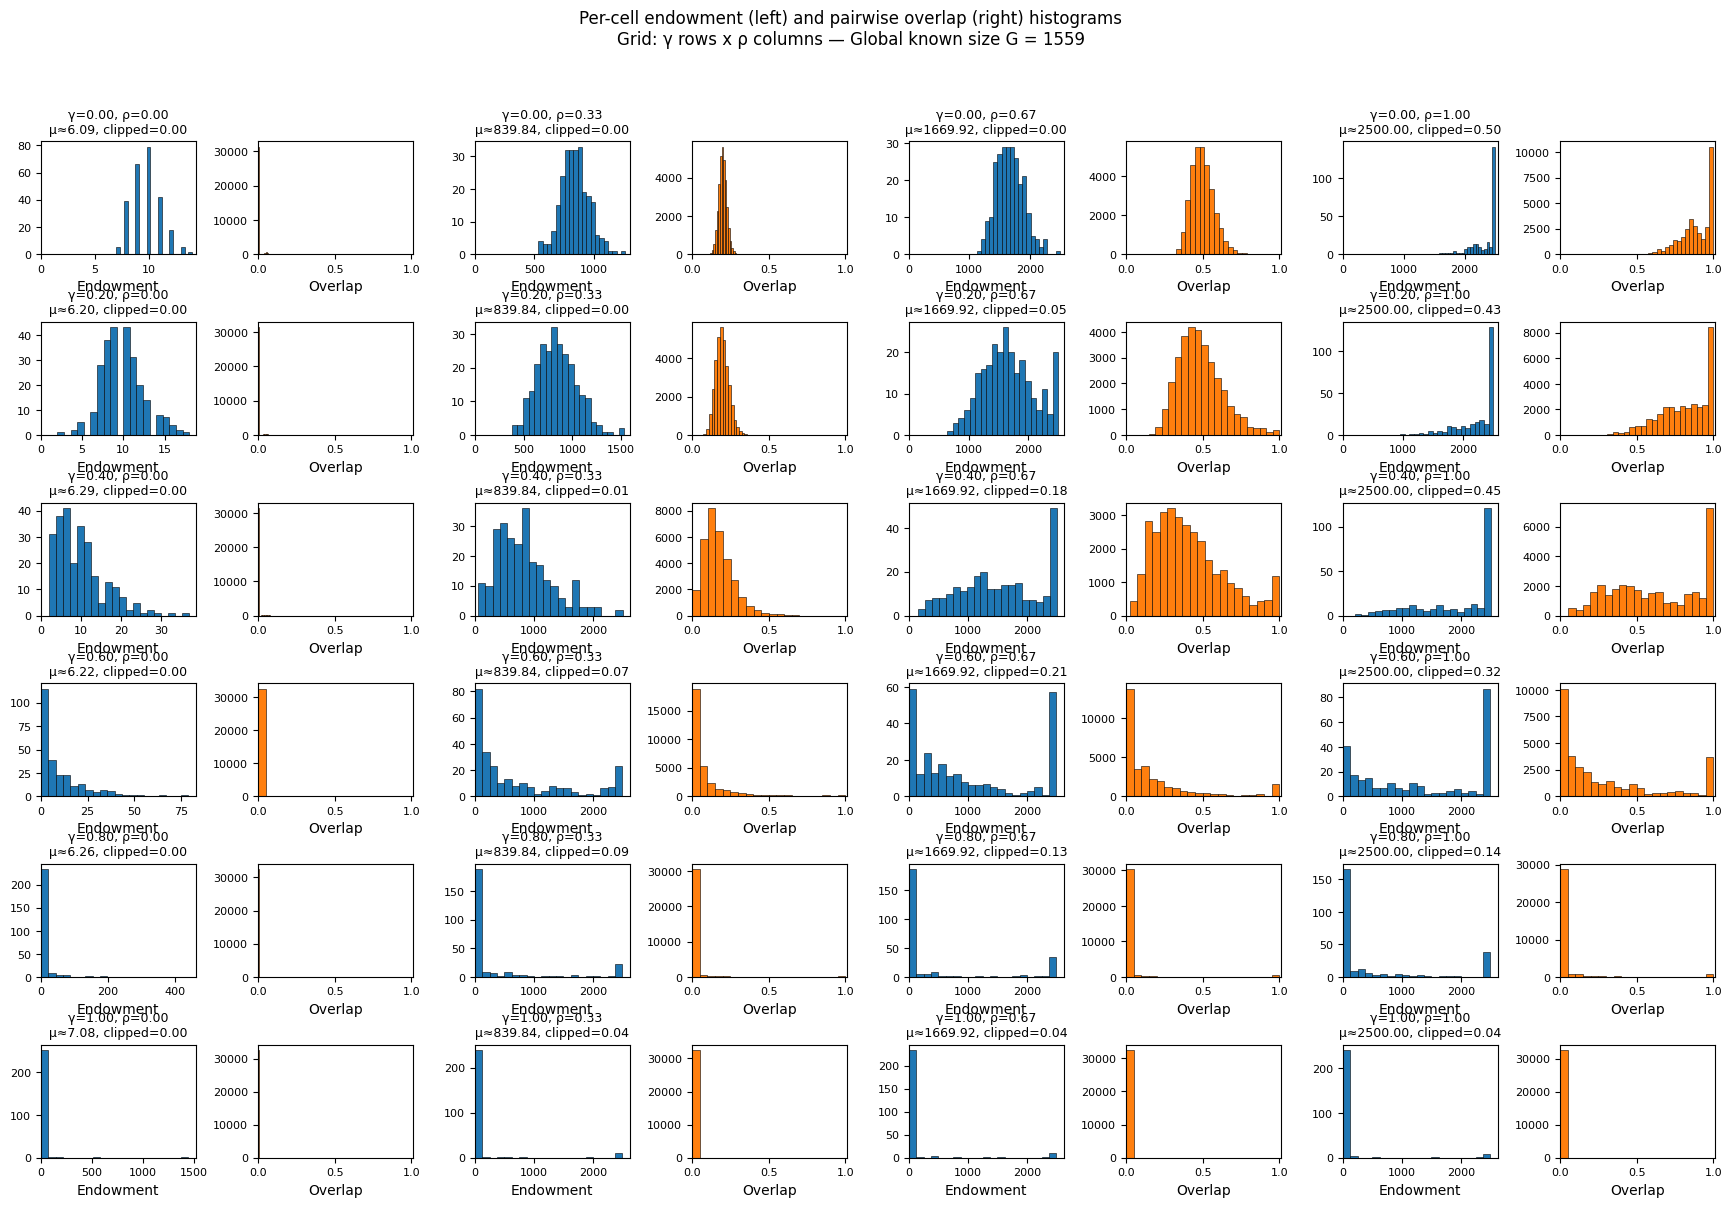

In [25]:
# Prepare large grid figure: a 6-row x (6*2)-col GridSpec,
# where each rho/gamma cell occupies two columns: left=endowment, right=overlap
fig_grid = plt.figure(figsize=(6 * 3.6, 6 * 2.2))  # width: 6 cells * 2 subplots * ~0.9, height moderate
outer_gs = gridspec.GridSpec(n_gamma, n_rho * 2, wspace=0.4, hspace=0.6)
color_endow = "tab:blue"
color_overlap = "tab:orange"
G_global = None  # will set from the first cell, then show once in the main title

# Loop gamma (rows) and rho (columns)
for i_g, gamma in enumerate(gammas):
    for i_r, rho in enumerate(rhos):
        # Construct SensingMasks for this (rho, gamma)
        sm = SensingMasks(TemporalData, rank, num_agents, density, future_only=future_only,
                          rho=float(rho), gamma=float(gamma), gamma_curve=1.2,
                          verbose=False)
        masks = sm.masks                            # shape [num_agents, total_entries]
        s_vec = sm.stats["agent_endowments"].cpu().numpy() if isinstance(sm.stats["agent_endowments"], torch.Tensor) else np.array(sm.stats["agent_endowments"])
        G = int(sm.global_known.sum().item())       # number of global-known entries
        if G_global is None:
            G_global = G
        
        # compute mu per plan
        mu = (1.0 - rho) * (G / float(max(1, num_agents))) + rho * float(G)
        fraction_clipped = float(sm.stats.get("fraction_clipped", 0.0))

        overlaps = compute_pairwise_overlaps_from_masks(masks)
        mean_overlap = float(np.mean(overlaps)) if overlaps.size > 0 else 0.0
        var_overlap = float(np.var(overlaps)) if overlaps.size > 0 else 0.0

        # save for scatter
        scatter_rho.append(rho)
        scatter_gamma.append(gamma)
        scatter_mean_overlap.append(mean_overlap)
        scatter_var_overlap.append(var_overlap)
        scatter_fraction_clipped.append(fraction_clipped)

        # plotting
        # compute which GridSpec cell indices to use: column pair index = 2*i_r, 2*i_r+1
        col_left = 2 * i_r
        col_right = 2 * i_r + 1
        gs_left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer_gs[i_g, col_left])
        gs_right = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer_gs[i_g, col_right])

        ax_left = fig_grid.add_subplot(gs_left[0])
        ax_right = fig_grid.add_subplot(gs_right[0])

        # left: endowment histogram
        ax_left.hist(s_vec, bins=20, edgecolor='black', linewidth=0.4, color=color_endow)
        ax_left.set_xlabel("Endowment")
        ax_left.set_ylabel("")
        ax_left.set_xlim(0.0, None)
        ax_left.tick_params(axis='both', which='major', labelsize=8)

        # right: overlap histogram
        ax_right.hist(overlaps, bins=20, edgecolor='black', linewidth=0.4, color=color_overlap)
        ax_right.set_xlabel("Overlap")
        ax_right.set_ylabel("")
        ax_right.set_xlim(0.0, 1.01)
        ax_right.tick_params(axis='both', which='major', labelsize=8)

        # title string
        title = f"γ={gamma:.2f}, ρ={rho:.2f}\nμ≈{mu:.2f}, clipped={fraction_clipped:.2f}"
        # place title over the two axes (center)
        ax_left.set_title(title, fontsize=9)

# Tight layout and save
fig_grid.suptitle(f"Per-cell endowment (left) and pairwise overlap (right) histograms\nGrid: γ rows x ρ columns — Global known size G = {G_global}", fontsize=12)
#plt.tight_layout(rect=[0, 0.03, 1, 0.96])
fig_grid.savefig("sensing_masks_grid_histograms.png", dpi=200)
print("Saved figure: sensing_masks_grid_histograms.png")

# --- Summary printout for quick inspection ---
print("\nSummary table (rho, gamma, mean_overlap, var_overlap, fraction_clipped):")
for rho, gamma, mo, vo, fc in zip(scatter_rho, scatter_gamma, scatter_mean_overlap, scatter_var_overlap, scatter_fraction_clipped):
    print(f"rho={rho:.2f}, gamma={gamma:.2f} -> mean={mo:.4f}, var={vo:.6f}, clipped_frac={fc:.3f}")

Saved figure: sensing_masks_rho_gamma_summary.png


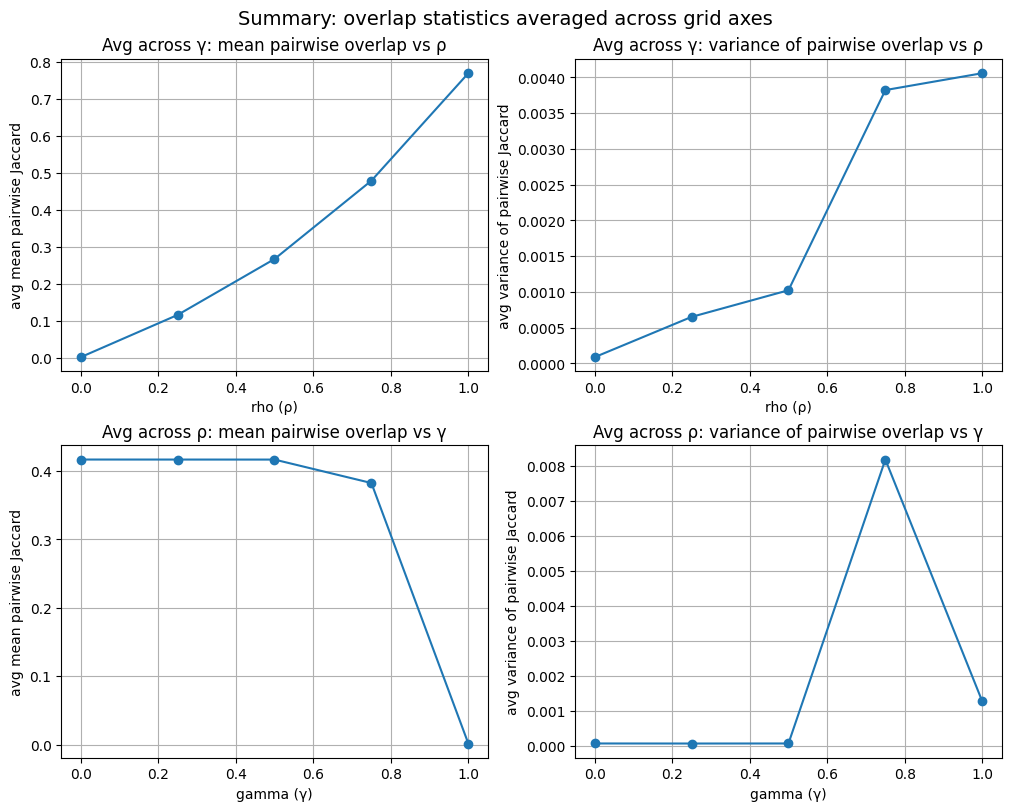

In [8]:
# ---- Replace previous scatter plot with this 4-subplot summary ----
# Assumes: numpy as np, plt, rhos (len n_rho), gammas (len n_gamma),
# scatter_mean_overlap, scatter_var_overlap, n_rho, n_gamma are defined.

# reshape collected metrics back to (n_gamma, n_rho) where rows=gamma, cols=rho
mean_mat = np.array(scatter_mean_overlap).reshape((n_gamma, n_rho))
var_mat  = np.array(scatter_var_overlap).reshape((n_gamma, n_rho))

# Averages across gamma (for each rho)
mean_over_gamma_for_rho = mean_mat.mean(axis=0)  # length n_rho
var_over_gamma_for_rho  = var_mat.mean(axis=0)

# Averages across rho (for each gamma)
mean_over_rho_for_gamma = mean_mat.mean(axis=1)  # length n_gamma
var_over_rho_for_gamma  = var_mat.mean(axis=1)

# create 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

# Top-left: avg (across gamma) mean pairwise overlap vs rho
ax = axes[0, 0]
ax.plot(rhos, mean_over_gamma_for_rho, marker='o', linestyle='-')
ax.set_xlabel("rho (ρ)")
ax.set_ylabel("avg mean pairwise Jaccard")
ax.set_title("Avg across γ: mean pairwise overlap vs ρ")
ax.grid(True)

# Top-right: avg (across gamma) variance of pairwise overlap vs rho
ax = axes[0, 1]
ax.plot(rhos, var_over_gamma_for_rho, marker='o', linestyle='-')
ax.set_xlabel("rho (ρ)")
ax.set_ylabel("avg variance of pairwise Jaccard")
ax.set_title("Avg across γ: variance of pairwise overlap vs ρ")
ax.grid(True)

# Bottom-left: avg (across rho) mean pairwise overlap vs gamma
ax = axes[1, 0]
ax.plot(gammas, mean_over_rho_for_gamma, marker='o', linestyle='-')
ax.set_xlabel("gamma (γ)")
ax.set_ylabel("avg mean pairwise Jaccard")
ax.set_title("Avg across ρ: mean pairwise overlap vs γ")
ax.grid(True)

# Bottom-right: avg (across rho) variance of pairwise overlap vs gamma
ax = axes[1, 1]
ax.plot(gammas, var_over_rho_for_gamma, marker='o', linestyle='-')
ax.set_xlabel("gamma (γ)")
ax.set_ylabel("avg variance of pairwise Jaccard")
ax.set_title("Avg across ρ: variance of pairwise overlap vs γ")
ax.grid(True)

fig.suptitle("Summary: overlap statistics averaged across grid axes", fontsize=14)
fig.savefig("sensing_masks_rho_gamma_summary.png", dpi=200)
print("Saved figure: sensing_masks_rho_gamma_summary.png")